Clustering hashtags and profiles

In [189]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('coolwarm')
%matplotlib inline

In [190]:
profile_df = pd.read_csv('Business Analytics/tagged_profiles.csv')

In [191]:
#profile_df.fillna('(0,0)',inplace=True)
profile_df.dropna(inplace=True)

In [192]:
profile_df['followers'] = profile_df['followers + post_count'].apply(lambda z: float(z.split(',')[0].replace('(','')))
profile_df['post_count'] = profile_df['followers + post_count'].apply(lambda z: float(z.split(',')[1].replace(')','')))

In [193]:
profile_df.drop('followers + post_count',axis=1,inplace=True)

In [194]:
profile_df.isna().sum()

n_posts       0
profile       0
followers     0
post_count    0
dtype: int64

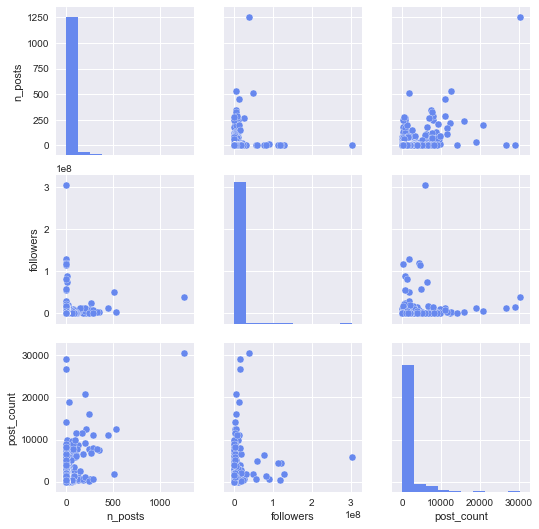

In [195]:
sns.pairplot(profile_df)

Now log transform n posts and followers, and normalize both datasets. 

In [196]:
profile_df.describe()

,n_posts,followers,post_count
count,771.000000,7.710000e+02,771.00000
mean,19.317769,2.936707e+06,1360.57847
std,68.555875,1.547512e+07,2923.75953
min,1.000000,0.000000e+00,0.00000
25%,1.000000,5.010000e+04,122.00000
50%,2.000000,1.770000e+05,389.00000
75%,8.000000,8.330000e+05,1098.50000
max,1255.000000,3.040000e+08,30420.00000


In [197]:
profile_df['followers'] = np.log10(profile_df['followers']+1)
profile_df['post_count'] = np.log10(profile_df['post_count']+1)

profile_df['n_posts'] = np.log10(profile_df['n_posts'])

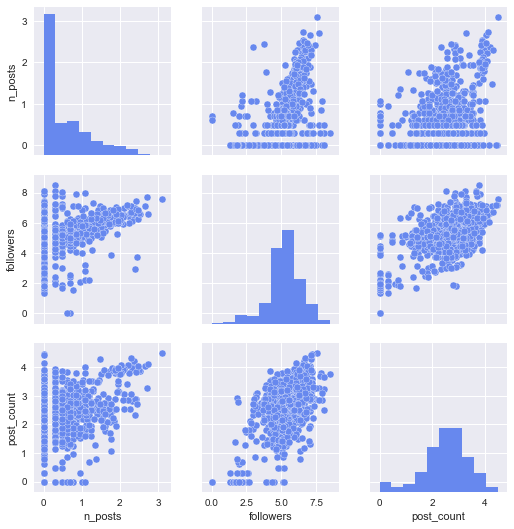

In [198]:
sns.pairplot(profile_df)

We now see a correlation between # of times a player is posted about on the nba insta, and how many followers he has. That's huge

In [199]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

x = profile_df.drop('profile',axis=1).values #returns a numpy array #removes missing followers (broken accounts)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


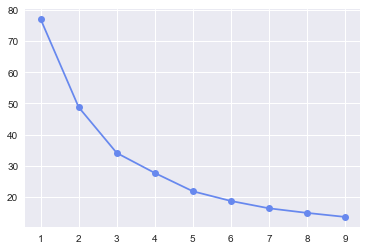

In [200]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    distortions.append(kmeanModel.inertia_)

plt.plot(K,distortions,'o-')

In [201]:
kmeanModel = KMeans(n_clusters=4).fit(df)

In [202]:
profile_df.dropna(subset=['followers'],inplace=True)
profile_df['Cluster'] = kmeanModel.labels_

In [23]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 0 to 791
Data columns (total 5 columns):
n_posts       771 non-null float64
profile       771 non-null object
followers     771 non-null float64
post_count    771 non-null float64
Cluster       771 non-null int32
dtypes: float64(3), int32(1), object(1)
memory usage: 33.1+ KB


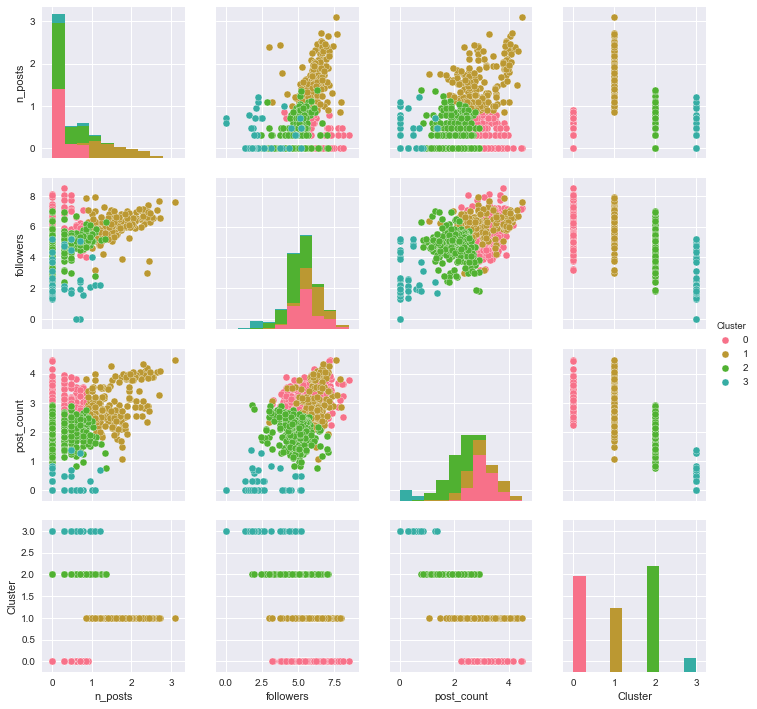

In [24]:
sns.set_palette('husl')
sns.pairplot(profile_df.drop('profile',axis=1),hue='Cluster')

In [25]:
profiles = profile_df[['profile','Cluster']].copy()
profiles = pd.get_dummies(profiles,columns=['Cluster'])

In [26]:
def apply_profile_clusters_to_training(z,profiles):
    """Apply the clusters to the dataset, now in a form for prediction aligned with the other data. 
   
   """
    
    import re
    from numpy import zeros
    post_clusters = zeros(profiles.shape[1] - 1)
    tags_in_z =  list( dict.fromkeys(re.findall('@[a-z_0-9]*',z)) ) 
    
    if len(tags_in_z) == 0:
        return post_clusters
    for tag_in_z in tags_in_z:
        try:
            post_clusters = post_clusters + profiles[profiles['profile'] == tag_in_z].values[0][1:] 
        except: 
            pass
    return post_clusters

In [27]:
instas = pd.read_csv('Business Analytics/training_set.csv',encoding = 'unicode_escape')

instas.fillna('',inplace=True)
instas['Clusters'] = instas['Description'].str.lower().apply(lambda z: apply_profile_clusters_to_training(z,profiles))
clusters = pd.DataFrame(instas.Clusters.tolist(), columns=['profiles_nC1', 'profiles_nC2','profiles_nC3','profiles_nC4'])

In [28]:
instas.head()

,Engagements,Followers at Posting,Created,Type,Description,Clusters
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,"[1.0, 2.0, 1.0, 0.0]"
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,"[0.0, 2.0, 0.0, 0.0]"
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,"[0.0, 2.0, 0.0, 0.0]"
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,"[0.0, 0.0, 0.0, 0.0]"
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,"[0.0, 1.0, 0.0, 0.0]"


In [29]:
instas = instas.merge(clusters,left_index=True,right_index=True).drop('Clusters',axis=1)

Now do the same for hashtags

In [30]:
hashtag_df = pd.read_csv('Business Analytics/used_hashtags.csv')

In [31]:
#hashtag_df.drop(columns=['max_eng','min_eng'],inplace=True)

hashtag_df = hashtag_df[['hashtags','n_posts','# of posts']]

In [32]:
hashtag_df.head()

,hashtags,n_posts,# of posts
0,#nbafinals,157,1662807.0
1,#gatoradezero,1,870.0
2,#nbaplayoffs,590,1500448.0
3,#tripledoublealert,111,2898.0
4,#powerbeatspro,2,1674.0


In [33]:
hashtag_df.isna().sum()

hashtags      0
n_posts       0
# of posts    0
dtype: int64

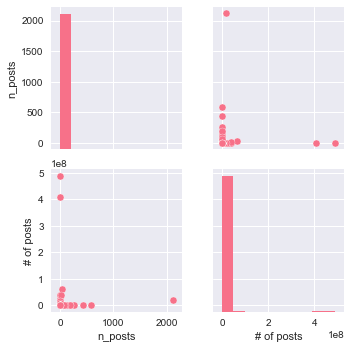

In [34]:
sns.pairplot(hashtag_df)

In [35]:
hashtag_df['# of posts'] = np.log10(hashtag_df['# of posts'] + 1)
hashtag_df['n_posts'] = np.log10(hashtag_df['n_posts'])

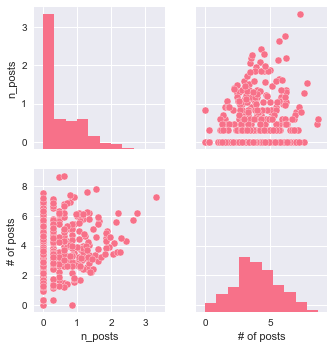

In [36]:
sns.pairplot(hashtag_df)

In [37]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

x = hashtag_df.drop('hashtags',axis=1).values #returns a numpy array #removes missing followers (broken accounts)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


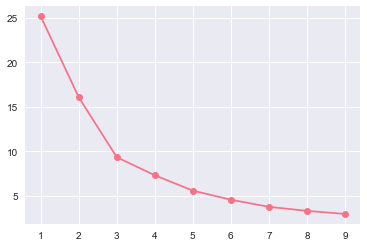

In [38]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    distortions.append(kmeanModel.inertia_)

plt.plot(K,distortions,'o-')

In [39]:
kmeanModel = KMeans(n_clusters=3).fit(df)

In [40]:
hashtag_df['Cluster'] = kmeanModel.labels_

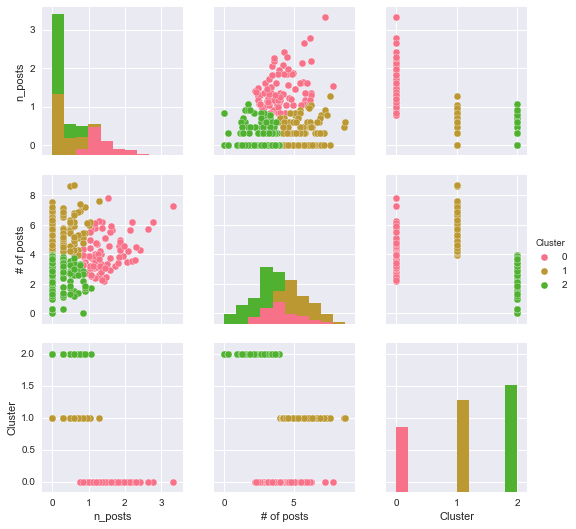

In [41]:
sns.pairplot(hashtag_df,hue='Cluster')

In [42]:
hashtags = hashtag_df[['hashtags','Cluster']].copy()
hashtags = pd.get_dummies(hashtags,columns=['Cluster'])

In [43]:
def apply_hashtag_clusters_to_training(z,hashtags):
    """Apply the clusters to the dataset, now in a form for prediction aligned with the other data. 
   
   """
    
    import re
    from numpy import zeros
    post_clusters = zeros(hashtags.shape[1] - 1)
    tags_in_z =  list( dict.fromkeys(re.findall('#[a-z_0-9]*',z)) ) 
    
    if len(tags_in_z) == 0:
        return post_clusters
    for tag_in_z in tags_in_z:
        #try:
        post_clusters = post_clusters + hashtags[hashtags['hashtags'] == tag_in_z].values[0][-(hashtags.shape[1] - 1):] 
       # except: 
       #     pass
    return post_clusters

In [44]:
hashtags.shape[1] -1

3

In [45]:
instas['HashtagClusters'] = instas['Description'].str.lower().apply(lambda z: apply_hashtag_clusters_to_training(z,hashtags))


In [46]:
clusters = pd.DataFrame(instas.HashtagClusters.tolist(), columns=['hashtags_nC1', 'hashtags_nC2','hashtags_nC3'])

In [47]:
instas = instas.merge(clusters,left_index=True,right_index=True).drop('HashtagClusters',axis=1)

#instas = instas.merge(clusters,left_index=True,right_index=True).drop('HashtagClusters',axis=1)
instas = pd.read_csv('Business Analytics/training_set.csv',encoding = 'unicode_escape')

instas.fillna('',inplace=True)

In [48]:
instas.columns

Index(['Engagements', 'Followers at Posting', 'Created', 'Type', 'Description',
       'profiles_nC1', 'profiles_nC2', 'profiles_nC3', 'profiles_nC4',
       'hashtags_nC1', 'hashtags_nC2', 'hashtags_nC3'],
      dtype='object')

In [49]:
instas['Description_Len'] = instas['Description'].apply(len)
instas['num@s'] = instas['Description'].apply(lambda z: z.count('@'))
instas['num#s'] = instas['Description'].apply(lambda z: z.count('#'))
instas['num?s'] = instas['Description'].apply(lambda z: z.count('?')) # a shitty proxy for emojis
import re
instas['numCAPs'] = instas['Description'].apply(lambda z: len(re.findall(r'[A-Z]',z)))

def find_dunks(z):
    dunk_words = ['slam','jam','finish','dunk','putback','rim','windmill','flush','oop']
    for dw in dunk_words:
        if dw in z.lower(): 
            return 1
    return 0

def find_buzzer_beaters(z):
    buzzer_beater_words = ['buzz','beat','clock','winner']
    
    for bbw in buzzer_beater_words:
        if bbw in z.lower():
            return 1

In [50]:
try:
    instas.drop('HashtagClusters',axis=1,inplace=True)
except:
    pass

# Modeling time!

In [51]:
import datetime


In [52]:
instas['Timezone'] = instas['Created'].str.split(' ',expand =True)[2]
instas['Date'] = instas['Created'].str.split(' ',expand = True)[0]
instas['Month'] = instas['Date'].str.split('-',expand = True)[1]

instas['Time'] = instas['Created'].str.split(' ',expand = True)[1]
instas['Hour'] = instas['Time'].str.split(':',expand=True)[0]

instas['Date'] = pd.to_datetime(instas['Date']).astype(datetime.datetime)

instas['Weekday'] = instas['Date'].apply(lambda z: z.weekday())
instas['Year'] = instas['Created'].apply(lambda z: z.split('-')[0])

In [53]:
instas['Description'].sample(n=5).values

array(['@kyrieirving dishes out a career-high 18 assists in the @celtics W!',
       'We got you! #ThisIsWhyWePlay',
       '@stephencurry30 and @kevindurant look to secure the ?? with a @warriors win (9:00pm/et #NBAonABC)!',
       '@jokara95 notches his first triple-double of the season for the @nuggets',
       '?? @joelembiid x @kevinhart4real ??! The @sixers are moving on. #PhilaUnite'],
      dtype=object)

In [54]:
instas.drop(columns=['Date','Time'],inplace=True)

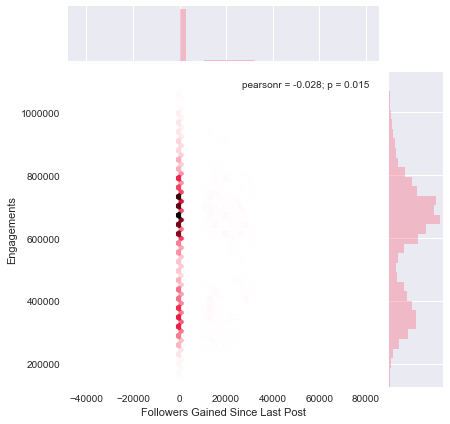

In [168]:
sns.jointplot('Followers Gained Since Last Post','Engagements',data = instas,kind='hex')

In [56]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [174]:
instas['Followers Gained Since Last Post'] = np.log10(-instas['Followers at Posting'].diff(1).fillna(0) + 1)

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


In [176]:
instas.describe()

,Engagements,Followers at Posting,profiles_nC1,profiles_nC2,profiles_nC3,profiles_nC4,hashtags_nC1,hashtags_nC2,hashtags_nC3,Description_Len,num@s,num#s,num?s,numCAPs,Weekday,Followers Gained Since Last Post
count,7.766000e+03,7.766000e+03,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7764.000000
mean,5.923129e+05,3.042770e+07,0.065671,1.301957,0.101210,0.013778,0.522663,0.037342,0.038372,69.053953,1.509014,0.599536,1.019057,5.626835,3.081767,0.326581
std,1.792682e+05,3.748957e+06,0.290327,1.079989,0.317031,0.117675,0.661080,0.196941,0.199344,37.143360,1.124158,0.716520,2.521439,6.012271,1.970062,1.136035
min,1.278160e+05,2.487554e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.173900e+05,2.698910e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,6.397285e+05,3.004747e+07,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000,1.000000,0.000000,0.000000,4.000000,3.000000,0.000000
75%,7.216282e+05,3.392854e+07,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,88.000000,2.000000,1.000000,1.000000,8.000000,5.000000,0.000000
max,1.129585e+06,3.698468e+07,4.000000,7.000000,3.000000,2.000000,5.000000,2.000000,2.000000,639.000000,10.000000,5.000000,34.000000,54.000000,6.000000,4.931712


In [177]:
X = instas.drop(columns=['Engagements','Description','Created','Followers at Posting']).copy()



/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


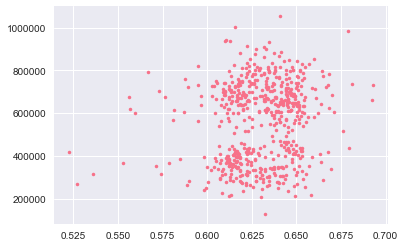

In [178]:
plt.plot(np.log10(instas['Followers Gained Since Last Post']), instas['Engagements'],'.')

In [179]:
X = pd.get_dummies(X)

In [180]:
X_norm  = normalize(X)

In [181]:
y = instas['Engagements']

In [182]:
import xgboost as xgb

In [188]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

model = xgb.XGBRegressor(n_estimators=550,booster='dart')#choice(models)

print("Model used: ", model)
model.fit(X_train,y_train,eval_metric=mean_absolute_percentage_error)
print("Training score: ", model.score(X_train,y_train))
print("Original Score", model.score(X_test,y_test))

def mean_absolute_percentage_error(y_true, y_pred):
    import numpy as np
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_true = y_test
y_pred = model.predict(X_test)
y_pred = [round(y) for y in y_pred]
#y_pred = np.array([round(y) for y in y_pred])
print("MAPE Original Score ", mean_absolute_percentage_error(y_true, y_pred))


Model used:  XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=550,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Training score:  0.9146530818067501
Original Score 0.8849518445001543
MAPE Original Score  6.796471868208437


In [154]:
X.shape

(7766, 58)

-1.0215390245373133

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x130bf1860>>
Traceback (most recent call last):
  File "/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


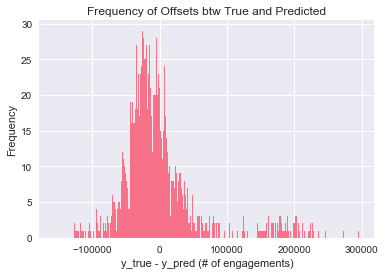

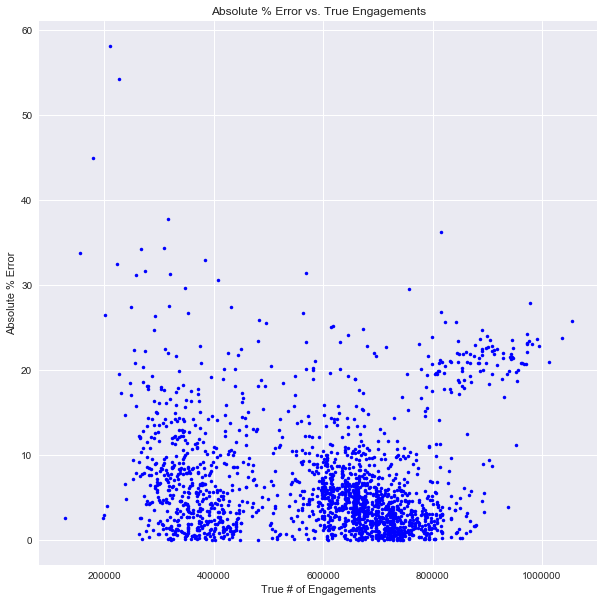

In [155]:
#what regression points are having the most trouble?
plt.title("Frequency of Offsets btw True and Predicted")
plt.hist(y_true.values - y_pred,bins=500)
plt.xlabel("y_true - y_pred (# of engagements)")
plt.ylabel("Frequency")
plt.figure(figsize=(10,10))
plt.plot(y_true.values,100*abs(y_true.values - y_pred)/ y_true.values,'b.')
plt.title("Absolute % Error vs. True Engagements")
plt.xlabel('True # of Engagements')
plt.ylabel('Absolute % Error')

So the worst guesses are occuring for the most viral posts. Let's see if there's anything we can do to fix that. 

Feature ranking:
1. feature 16 (0.741091)
Type_Video
2. feature 8 (0.051122)
num@s
3. feature 25 (0.021664)
Month_07
4. feature 7 (0.018277)
Description_Len
5. feature 1 (0.017572)
profiles_nC2
6. feature 12 (0.016980)
Weekday
7. feature 10 (0.011046)
num?s
8. feature 11 (0.010799)
numCAPs
9. feature 23 (0.005044)
Month_05
10. feature 4 (0.005007)
hashtags_nC1
11. feature 27 (0.004550)
Month_09
12. feature 9 (0.004482)
num#s
13. feature 51 (0.004009)
Hour_20
14. feature 32 (0.003755)
Hour_01
15. feature 26 (0.003663)
Month_08
16. feature 20 (0.003631)
Month_02
17. feature 52 (0.003611)
Hour_21
18. feature 54 (0.003529)
Hour_23
19. feature 56 (0.003287)
Year_2018
20. feature 28 (0.003248)
Month_10
21. feature 53 (0.003215)
Hour_22
22. feature 31 (0.003201)
Hour_00
23. feature 49 (0.003148)
Hour_18
24. feature 17 (0.002878)
Timezone_EDT
25. feature 30 (0.002809)
Month_12
26. feature 2 (0.002787)
profiles_nC3
27. feature 22 (0.002752)
Month_04
28. feature 48 (0.002731)
Hour_17
29. feature

(-1, 58)

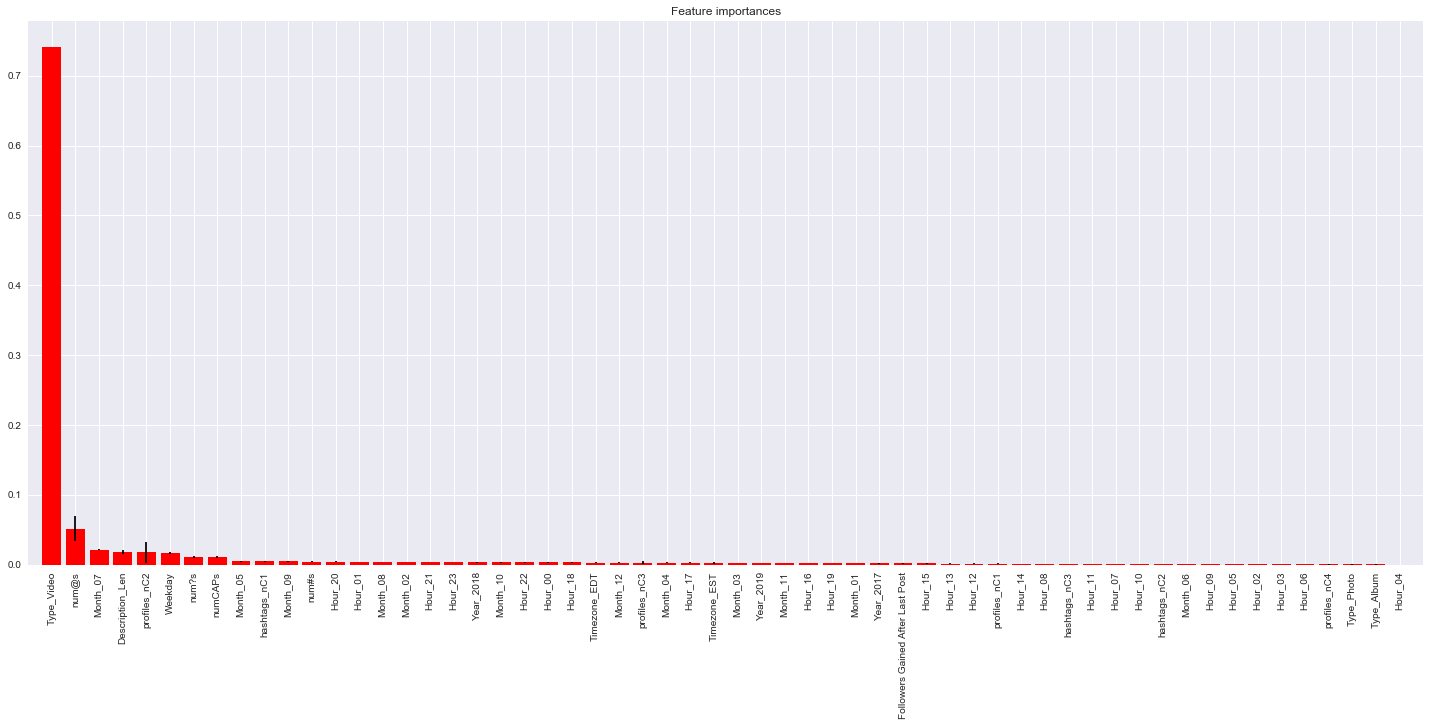

In [156]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesRegressor

# Build a classification task using 3 informative features

# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)
 
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
col_names = []
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(X.columns[indices[f]])
    col_names.append(X.columns[indices[f]])

# Plot the feature importances of the forest
plt.figure(figsize=(25,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), col_names,rotation=90)
plt.xlim([-1, X.shape[1]])


In [157]:
X.columns

Index(['profiles_nC1', 'profiles_nC2', 'profiles_nC3', 'profiles_nC4',
       'hashtags_nC1', 'hashtags_nC2', 'hashtags_nC3', 'Description_Len',
       'num@s', 'num#s', 'num?s', 'numCAPs', 'Weekday',
       'Followers Gained After Last Post', 'Type_Album', 'Type_Photo',
       'Type_Video', 'Timezone_EDT', 'Timezone_EST', 'Month_01', 'Month_02',
       'Month_03', 'Month_04', 'Month_05', 'Month_06', 'Month_07', 'Month_08',
       'Month_09', 'Month_10', 'Month_11', 'Month_12', 'Hour_00', 'Hour_01',
       'Hour_02', 'Hour_03', 'Hour_04', 'Hour_05', 'Hour_06', 'Hour_07',
       'Hour_08', 'Hour_09', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13',
       'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19',
       'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Year_2017', 'Year_2018',
       'Year_2019'],
      dtype='object')

In [85]:
insta_corpus = " ".join(instas['Description'].values)

In [86]:
insta_corpus

'The @raptors bench trio of @sergeibaka @normanpowell4 & @fredvanvleet combine for 48 in Game 4! @kyle_lowry7 pulls from deep for the @raptors in the 4th on TNT! @k_mid22 with some english on the @bucks dime! Kawhi punches it home with the left on TNT! @giannis_an34 goes baseline early to rock the rim on TNT! Congrats to the 2018-19 NBA All-Rookie First Team, led by unanimous selections @lukadoncic & @traeyoung! The @warriors locked in for four games to advance to the #NBAFinals presented by YouTube TV! #GatoradeZero Will the @bucks take a commanding 3-1 lead... or will the @raptors even the ECF up 2-2?? TAP to SHOP the @warriors Western Conference Champions gear from @nbastore! Hey @stephencurry30... that was the first time teammates had triple-doubles in the same #NBAPlayoffs game in @nbahistory! @stephencurry30 (37/13/11) & @money23green (18/14/11) become the first teammates in #NBAPlayoffs history to record a triple-double in the same game! The @warriors defeat @trailblazers 119-11

In [87]:
import re
import string
from nltk.corpus import stopwords
stoplist = stopwords.words('dutch')

from collections import defaultdict
from operator import itemgetter

def toptenwords(mycorpus):
    words = mycorpus.words()
    no_capitals = set([word.lower() for word in words]) 
    filtered = [word for word in no_capitals if word not in stoplist]
    no_punct = [s.translate(None, string.punctuation) for s in filtered] 
    wordcounter = {}
    for word in no_punct:
        if word in wordcounter:
            wordcounter[word] += 1
        else:
            wordcounter[word] = 1
    sorting = sorted(wordcounter.iteritems(), key = itemgetter, reverse = True)
    return sorting 

In [97]:

# Python program to find the k most frequent words 
# from data set 
from collections import Counter 
  
data_set = insta_corpus
# split() returns list of all the words in the string 
split_it = data_set.split() 
  
# Pass the split_it list to instance of Counter class. 
Counter = Counter(split_it) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common(100) 
  
print(most_occur) 

[('the', 6244), ('for', 2307), ('in', 1693), ('to', 1685), ('of', 1231), ('??', 1140), ('with', 1068), ('The', 1006), ('on', 925), ('his', 689), ('a', 661), ('&', 657), ('up', 657), ('and', 566), ('#NBAPlayoffs', 553), ('it', 447), ('from', 442), ('#ThisIsWhyWePlay', 422), ('??:', 412), ('at', 368), ('@kingjames', 358), ('NBA', 342), ('tonight\x92s', 310), ('off', 307), ('@warriors', 279), ('(??:', 278), ('action', 256), ('????', 247), ('action!', 244), ('Game', 243), ('triple-double', 231), ('#NBAonABC', 230), ('through', 224), ('season', 215), ('first', 213), ('gets', 212), ('@houstonrockets', 205), ('TOP', 203), ('@jharden13', 194), ('?:', 193), ('...', 191), ('@celtics', 188), ('Conference', 187), ('@stephencurry30', 185), ('by', 184), ('2018', 184), ('SLAM!', 183), ('lead', 175), ('3', 175), ('@cavs', 170), ('out', 169), ('@giannis_an34', 165), ('@sixers', 163), ('(repost', 162), ('we', 161), ('x', 155), ('#KiaTipOff18', 155), ('each', 153), ('this', 152), ('@russwest44', 152), ('

In [94]:
type(insta_corpus)

str